# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512 $\times$ 512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


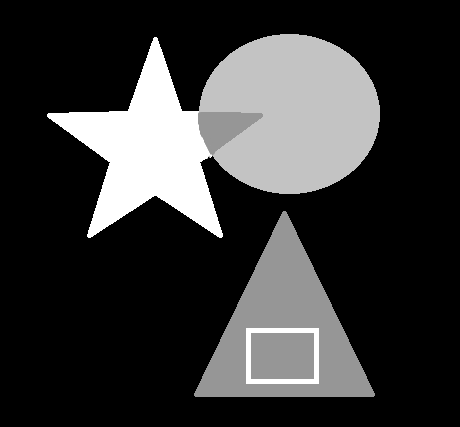


In [3]:
# Font per pyplot
plt.rcParams.update({'font.size': 15})

# Alias per le funzioni
f_MSE = metrics.mean_squared_error
f_PSNR = metrics.peak_signal_noise_ratio


## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

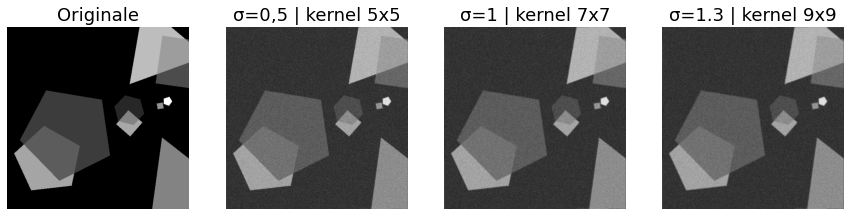

In [4]:
def gaussian_blur(image_size, kernel_len, sigma): 
    """
        Restituisce l'operatore di blur
    """
    return psf_fft(gaussian_kernel(kernel_len, sigma), kernel_len, image_size)


# real_image = data.camera().astype(np.float64) / 255.0
real_image = plt.imread("./dataset/image1.png").astype(np.float64)

# Filtro blur (A)
blur1 = gaussian_blur(real_image.shape, 5, 0.5)
blur2 = gaussian_blur(real_image.shape, 7, 1)
blur3 = gaussian_blur(real_image.shape, 9, 1.3)

# Filtro rumore (η)
dev = 0.05
noise = np.random.normal(size=real_image.shape) * dev

image1 = A(real_image, blur1) + noise
image2 = A(real_image, blur2) + noise
image3 = A(real_image, blur3) + noise


fig, ax = plt.subplots(1, 4, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0].imshow(real_image, cmap="gray")
ax[0].set_title("Originale")
ax[0].axis("off")

ax[1].imshow(image1, cmap="gray")
ax[1].set_title("σ=0,5 | kernel 5x5")
ax[1].axis("off")

ax[2].imshow(image2, cmap="gray")
ax[2].set_title("σ=1 | kernel 7x7")
ax[2].axis("off")

ax[3].imshow(image3, cmap="gray")
ax[3].set_title("σ=1.3 | kernel 9x9")
ax[3].axis("off")

plt.show()

## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [6]:
def f_naive(x, image, blur):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2)

def df_naive(x, image, blur):
    x = x.reshape(image.shape)
    return (AT(A(x, blur), blur) - AT(image, blur)).reshape(-1)
    

def deblur_naive(image, blur, tol=None, max_iter=1000, callback=None):
    """
        Esegue il deblur con il metodo naive con minimizzazione tramite gradiente coniugato

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_naive(x, image, blur)
    def df(x):
        return df_naive(x, image, blur)

    out = minimize(
        fun = f, 
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


## 3) Regolarizzazione

Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [8]:
def f_tikhonov(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2) + (lamb / 2) * (np.linalg.norm(x)**2)

def df_tikhonov(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (AT(A(x, blur), blur) - AT(image, blur) + (lamb * x)).reshape(-1)
    

def deblur_tikhonov_cg(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    """
        Esegue il deblur con regolarizzazione di Tikhonov con minimizzazione tramite gradiente coniugato

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            lamb      :  Valore del parametro di regolarizzazione
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_tikhonov(x, image, blur, lamb)
    def df(x):
        return df_tikhonov(x, image, blur, lamb)

    out = minimize(
        fun = f, 
        x0 = np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


In [9]:
def next_step(f, x, grad, max_iter=10):
    """
        Algoritmo di backtracking per ricavare la lunghezza del passo
    """
    alpha = 1.1
    rho = 0.5
    c1 = 0.25
    p = -grad
    j = 0

    while ((f(x + alpha * p) > f(x) + c1 * alpha * grad.T @ p) and j < max_iter):
        alpha = rho * alpha
        j += 1

    if (j > max_iter):
        return -1
    else:
        return alpha

def gradiente(f, grad_f, x0, step, max_iter, tol, callback):
    """
        Implementazione del metodo del gradiente
    """
    x_last = np.array(x0)
    k = 0

    while (np.linalg.norm(grad_f(x_last)) > tol and k < max_iter ):
        k = k+1
        grad = grad_f(x_last)
        step = next_step(f, x_last, grad)
        
        # Non convergenza
        if (step == -1):
            raise ArithmeticError("Non converge")

        x_last= x_last - step*grad

        if callback is not None:
            if callback(x_last):
                break
  
    return (x_last, k)


def deblur_tikhonov_gd(image, blur, lamb, tol=1.e-5, max_iter=1000, callback=None):
    """
        Esegue il deblur con regolarizzazione di Tikhonov con minimizzazione tramite metodo del gradiente

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            lamb      :  Valore del parametro di regolarizzazione
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_tikhonov(x, image, blur, lamb)
    def df(x):
        return df_tikhonov(x, image, blur, lamb)

    x0 = np.zeros(image.size)

    out, n_it = gradiente(
        f = f,
        grad_f = df,
        x0 = x0,
        step = next_step(f, x0, df(x0)),
        max_iter = max_iter,
        tol = tol,
        callback = callback
    )

    return {"image": out.reshape(image.shape), "n_it": n_it}


## 4) Variazione Totale (Facoltativo) 

Un'altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [12]:
eps = 1e-2

# Variazione totale
def totvar(x):
    # Calcola il gradiente di x
    dx, dy = np.gradient(x)
    n2 = np.square(dx) + np.square(dy)

    # Calcola la variazione totale di x
    tv = np.sqrt(n2 + eps**2).sum()
    return tv

# Gradiente della variazione totale
def grad_totvar(x):
    # Calcola il numeratore della frazione
    dx, dy = np.gradient(x)

    # Calcola il denominatore della frazione
    n2 = np.square(dx) + np.square(dy)
    den = np.sqrt(n2 + eps**2)

    # Calcola le due componenti di F dividendo il gradiente per il denominatore
    Fx = dx / den
    Fy = dy / den

    # Calcola la derivata orizzontale di Fx 
    dFdx = np.gradient(Fx, axis=0)
    
    # Calcola la derivata verticale di Fy
    dFdy = np.gradient(Fy, axis=1)

    # Calcola la divergenza 
    div = (dFdx + dFdy)

    # Restituisci il valore del gradiente della variazione totale
    return -div


In [14]:
def f_tv(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2) + (lamb * totvar(x))

def df_tv(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return ((AT(A(x, blur), blur) - AT(image, blur)) + (lamb * grad_totvar(x))).reshape(-1)
    

def deblur_tv(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    """
        Esegue il deblur con regolarizzazione tramite variazione totale con minimizzazione tramite gradiente coniugato

        PARAMETRI:
            image     :  Immagine acqusita
            blur      :  Operatore di blur
            lamb      :  Valore del parametro di regolarizzazione
            tol       :  Tolleranza del metodo di discesa
            max_iter  :  Numero massimo di iterazioni
            callback  :  Funzione che viene richiamata ad ogni iterazione. Deve essere nella forma (xk) -> bool. Se ritorna True, l'algoritmo termina.

        RETURN:
            Dizionario con campi:
                'image' :  Matrice Numpy contenente l'immagine calcolata
                'n_it'  :  Numero di iterazioni impiegate
    """
    def f(x):
        return f_tv(x, image, blur, lamb)
    def df(x):
        return df_tv(x, image, blur, lamb)

    out = minimize(
        fun = f,
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter},
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


# <hr>

In [106]:
# Solo per fermare il run all
# while True:
#     pass

In [15]:
curr_real = real_image
curr_image = image1
curr_blur = blur1

# Analisi dei metodi regolarizzati

Analisi delle prestazioni dei metodi regolarizzati al variare di $\lambda$. \
Viene eseguita la valutazione del PSNR con $\lambda \in [0.01, 1[$

In [108]:
def plot_lambda_difference(lambdas, psnrs, title):
    """
        Plot del PSNR al variare di lambda
    """
    
    max_i = psnrs.index(max(psnrs))  # Indice del punto migliore

    plt.figure(figsize=(10, 6), dpi=80)

    plt.grid()
    plt.title(title)
    plt.xlabel("λ")
    plt.ylabel("PSNR")

    plt.plot(lambdas, psnrs)

    # Punto migliore
    plt.plot(lambdas[max_i], psnrs[max_i], "*")
    plt.annotate(f" λ ≈ {round(lambdas[max_i], 5)}", (lambdas[max_i], psnrs[max_i]))
    
    plt.show()


## Tikhonov con gradiente coniugato

0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 

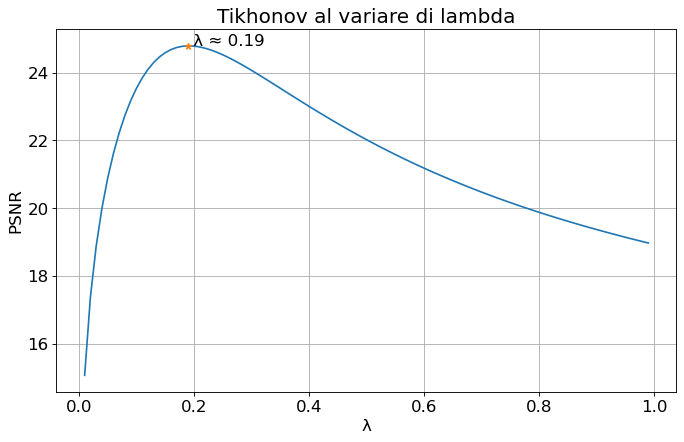

lambda = 0.19 | PSNR = 24.789943407554755


In [109]:
x_tikhonov1 = np.arange(0.01, 1, 0.01)
y_tikhonov1 = []

for lamb in x_tikhonov1:
    print(round(lamb, 3), end=" ")
    out = deblur_tikhonov_cg(curr_image, curr_blur, lamb)
    y_tikhonov1.append(f_PSNR(curr_real, out["image"]))


plot_lambda_difference(x_tikhonov1, y_tikhonov1, "Tikhonov al variare di lambda")

max_i = y_tikhonov1.index(max(y_tikhonov1))  # Indice del punto migliore
print(f"lambda = {x_tikhonov1[max_i]} | PSNR = {y_tikhonov1[max_i]}")
tikhonov_best_lambda = x_tikhonov1[max_i]


## Variazione totale

0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 

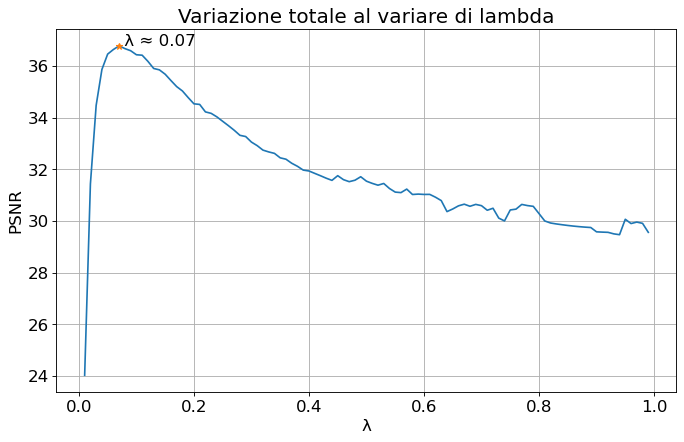

lambda = 0.06999999999999999 | PSNR = 36.77919339442501


In [110]:
x_tv1 = np.arange(0.01, 1, 0.01)
y_tv1 = []

for lamb in x_tv1:
    print(round(lamb, 3), end=" ")
    out = deblur_tv(curr_image, curr_blur, lamb)
    y_tv1.append(f_PSNR(curr_real, out["image"]))


plot_lambda_difference(x_tv1, y_tv1, "Variazione totale al variare di lambda")

max_i = y_tv1.index(max(y_tv1))  # Indice del punto migliore
print(f"lambda = {x_tv1[max_i]} | PSNR = {y_tv1[max_i]}")
tv_best_lambda = x_tv1[max_i]


## Generalizzazione

In [16]:
def search_best_lambda(method, real_image, image, blur, start=0.01, end=1, accuracy=0.01):
    """
        Cerca iterativamente il miglior valore di lambda confrontando il PSNR

        PARAMETRI:
            method                   :  Funzione di deblur per cui cercare
            real_image, image, blur  :  Informazioni sull'immagine a cui applicare il metodo
            start, end               :  Intervallo di ricerca [start, end[
            accuracy                 :  Accuratezza del valore di lambda (min 0.1)

        RETURN:
            best_lambda  :  Valore di lambda ottimale trovato

        Nota: Una implementazione più intelligente consiste nel restituire, oltre a lambda, l'output dell'esecuzione migliore associata a lambda (salvandolo durante le varie iterazioni).
              Abbiamo deciso di restituire solo lambda per mantenere separate la fase di ricerca di lambda e quella di esecuzione dell'algoritmo.
    """

    step = 0.1
    lambdas = np.arange(start, end, step)
    best_lambda = None
    best_psnr = float('-inf')

    while step >= accuracy:
        # Eseguo il metodo per ogni lambda dell'intervallo e salvo il migliore
        for lamb in lambdas:
            out = method(image, blur, lamb)
            if f_PSNR(real_image, out["image"]) > best_psnr:
                best_psnr = f_PSNR(real_image, out["image"])
                best_lambda = lamb
        
        # Determino il nuovo intervallo
        new_start = best_lambda - step
        if new_start < 0:
            new_start = start
        new_end = best_lambda + step
        step = step/10
        lambdas = np.arange(new_start, new_end, step)
        
    return best_lambda


# Esecuzione preliminare

Esecuzione dei metodi applicati ad un'immagine per una prima valutazione delle prestazioni dei metodi

In [17]:
lambda_tikhonov = search_best_lambda(deblur_tikhonov_cg, curr_real, curr_image, curr_blur, start=0.01, end=0.5, accuracy=0.01)
lambda_tv = search_best_lambda(deblur_tv, curr_real, curr_image, curr_blur, start=0.01, end=0.5, accuracy=0.01)

# lambda_tikhonov = 0.19
# lambda_tv = 0.07


In [32]:
out_naive = deblur_naive(curr_image, curr_blur, max_iter=200)
print("OK - Naive")

out_tikhonov_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov)
print("OK - Tikhonov CG")

out_tikhonov_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov)
print("OK - Tikhonov GD")

out_tv = deblur_tv(curr_image, curr_blur, lambda_tv)
print("OK - TV")

OK - Naive
OK - Tikhonov CG
OK - Tikhonov GD
OK - TV


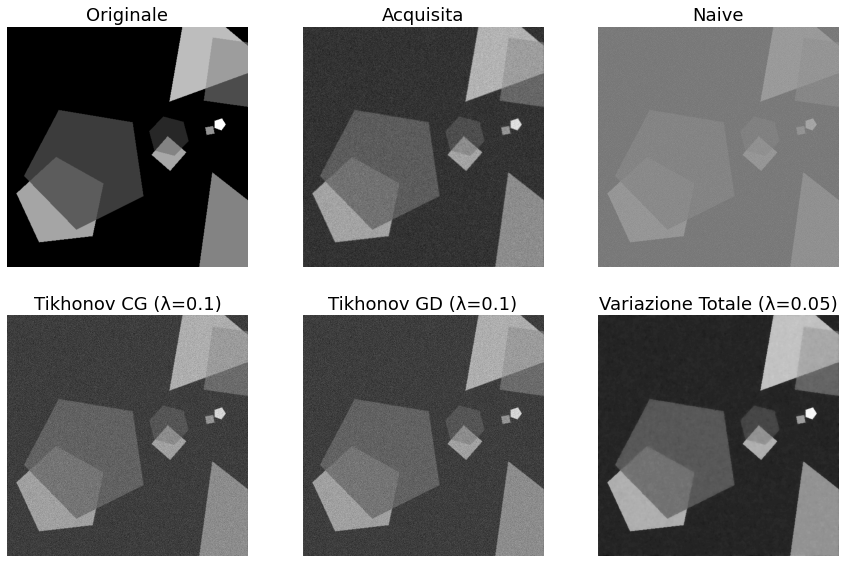

           Acquisita                 Naive                     Tikhonov CG               Tikhonov GD               Variazione totale        
MSE        0.0026837428157226264     0.2026700036447262        0.004421562447894747      0.00442154480853324       0.0002279529692082097    
PSNR       25.712591051439375        6.9321052469416475        23.54424236851591         23.544259694275162        36.42154746509429        
Iter.                                139                       18                        92                        14                       


In [33]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0, 0].imshow(curr_real, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")

ax[0, 1].imshow(curr_image, cmap="gray")
ax[0, 1].set_title("Acquisita")
ax[0, 1].axis("off")

ax[0, 2].imshow(out_naive["image"], cmap="gray")
ax[0, 2].set_title(f"Naive")
ax[0, 2].axis("off")

ax[1, 0].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[1, 0].set_title(f"Tikhonov CG (λ={round(lambda_tikhonov, 2)})")
ax[1, 0].axis("off")

ax[1, 1].imshow(out_tikhonov_gd["image"], cmap="gray")
ax[1, 1].set_title(f"Tikhonov GD (λ={round(lambda_tikhonov, 2)})")
ax[1, 1].axis("off")

ax[1, 2].imshow(out_tv["image"], cmap="gray")
ax[1, 2].set_title(f"Variazione Totale (λ={round(lambda_tv, 2)})")
ax[1, 2].axis("off")

plt.show()

print(f"{'':<10} {'Acquisita':<25} {'Naive':<25} {'Tikhonov CG':<25} {'Tikhonov GD':<25} {'Variazione totale':<25}")
print(f"{'MSE':<10} {f_MSE(curr_real, curr_image):<25} {f_MSE(curr_real, out_naive['image']):<25} {f_MSE(curr_real, out_tikhonov_cg['image']):<25} {f_MSE(curr_real, out_tikhonov_gd['image']):<25} {f_MSE(curr_real, out_tv['image']):<25}")
print(f"{'PSNR':<10} {f_PSNR(curr_real, curr_image):<25} {f_PSNR(curr_real, out_naive['image']):<25} {f_PSNR(curr_real, out_tikhonov_cg['image']):<25} {f_PSNR(curr_real, out_tikhonov_gd['image']):<25} {f_PSNR(curr_real, out_tv['image']):<25}")
print(f"{'Iter.':<10} {'':<25} {out_naive['n_it']:<25} {out_tikhonov_cg['n_it']:<25} {out_tikhonov_gd['n_it']:<25} {out_tv['n_it']:<25}")

# Confronto prestazioni Tikhonov con Gradiente Coniugato e Metodo del Gradiente

Analisi del comportamento dei metodi con discesa CG e GD al variare della tolleranza in termini di errore e numero di iterazioni.

## Analisi al variare della tolleranza

In [115]:
tols = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

n_it_cg = []
n_it_gd = []
psnr_cg = []
psnr_gd = []

for tol in tols:
    print(tol, end=" ")
    
    out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, tol=tol)
    n_it_cg.append(out_cg["n_it"])
    psnr_cg.append(f_PSNR(curr_real, out_cg["image"]))
    
    out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, tol=tol)
    n_it_gd.append(out_gd["n_it"])
    psnr_gd.append(f_PSNR(curr_real, out_gd["image"]))


0.1 0.01 0.001 0.0001 1e-05 1e-06 1e-07 1e-08 

### Analisi del numero di iterazioni al variare della tolleranza

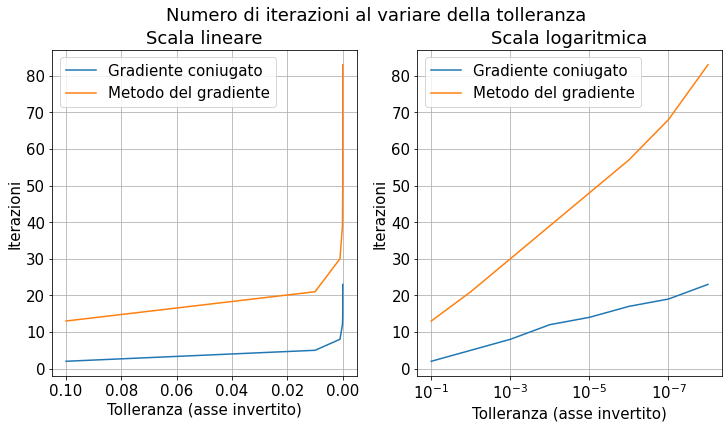

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Numero di iterazioni al variare della tolleranza")

ax[0].grid()
ax[0].set_title("Scala lineare")
ax[0].set_xlabel("Tolleranza (asse invertito)")
ax[0].set_ylabel("Iterazioni")
ax[0].invert_xaxis()
ax[0].plot(tols, n_it_cg, label="Gradiente coniugato")
ax[0].plot(tols, n_it_gd, label="Metodo del gradiente")
ax[0].legend()

ax[1].grid()
ax[1].set_title("Scala logaritmica")
ax[1].set_xlabel("Tolleranza (asse invertito)")
ax[1].set_ylabel("Iterazioni")
ax[1].invert_xaxis()
ax[1].set_xscale('log')
ax[1].plot(tols, n_it_cg, label="Gradiente coniugato")
ax[1].plot(tols, n_it_gd, label="Metodo del gradiente")
ax[1].legend()

plt.show()

### Analisi del PSNR al variare della tolleranza

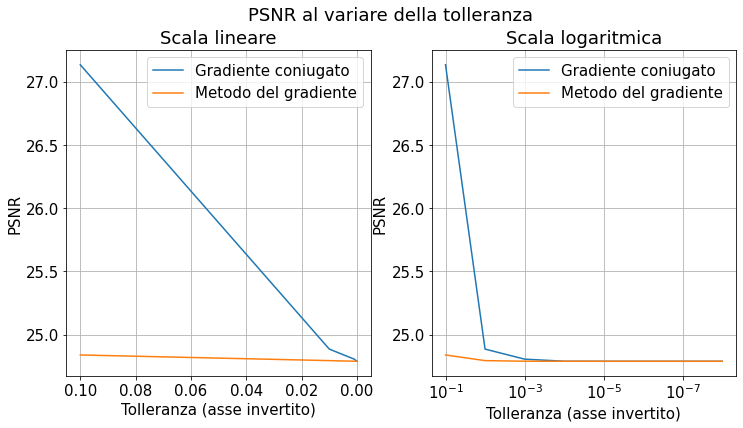

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PSNR al variare della tolleranza")

ax[0].grid()
ax[0].set_title("Scala lineare")
ax[0].set_xlabel("Tolleranza (asse invertito)")
ax[0].set_ylabel("PSNR")
ax[0].invert_xaxis()
ax[0].plot(tols, psnr_cg, label="Gradiente coniugato")
ax[0].plot(tols, psnr_gd, label="Metodo del gradiente")
ax[0].legend()

ax[1].grid()
ax[1].set_title("Scala logaritmica")
ax[1].set_xlabel("Tolleranza (asse invertito)")
ax[1].set_ylabel("PSNR")
ax[1].invert_xaxis()
ax[1].set_xscale("log")
ax[1].plot(tols, psnr_cg, label="Gradiente coniugato")
ax[1].plot(tols, psnr_gd, label="Metodo del gradiente")
ax[1].legend()

plt.show()


## Funzione obiettivo / Norma del gradiente

In [118]:
def append_to(xk, list):
    list.append(xk)

In [119]:
xk_cg = [np.zeros(curr_image.size)]
xk_gd = [np.zeros(curr_image.size)]

out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, callback=lambda xk: append_to(xk, xk_cg))
out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, callback=lambda xk: append_to(xk, xk_gd))

In [120]:
# Funzione obiettivo all'iterazione k-esima
f_k_cg = [f_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov) for xk in xk_cg]
f_k_gd = [f_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov) for xk in xk_gd]

# Gradiente all'iterazione k-esima
df_k_cg = [np.linalg.norm(df_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov)) for xk in xk_cg]
df_k_gd = [np.linalg.norm(df_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov)) for xk in xk_gd]

# Differenza tra f_gd e f_cg all'iterazione k-esima
diff_f = [f_k_gd[i] - f_k_cg[i] for i in range(len(f_k_cg))]

# Differenza tra df_gd e df_cg all'iterazione k-esima
diff_df = [df_k_gd[i] - df_k_cg[i] for i in range(len(df_k_cg))]


### Analisi dell'andamento della funzione obiettivo

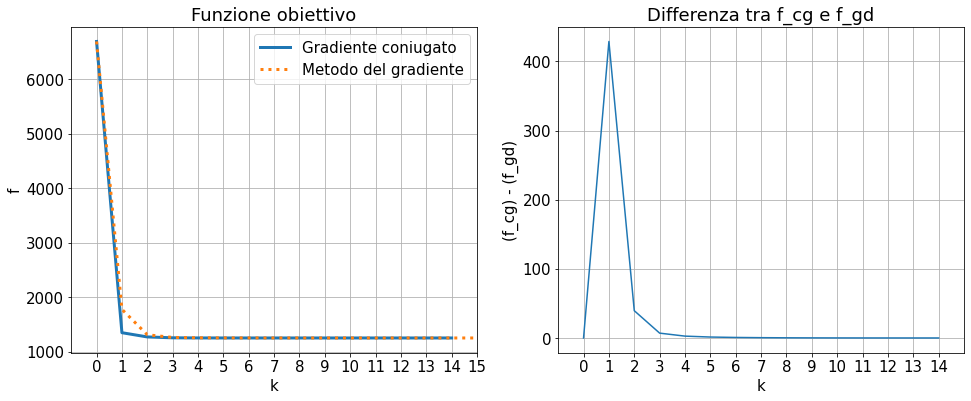

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].grid()
ax[0].set_title("Funzione obiettivo")
ax[0].set_xlabel("k")
ax[0].set_ylabel("f")
ax[0].plot(range(0, len(f_k_cg)), f_k_cg, label="Gradiente coniugato", linewidth=3)
ax[0].plot(range(0, len(f_k_gd)), f_k_gd, label="Metodo del gradiente", linestyle=":", linewidth=3)
ax[0].legend()
ax[0].set_xticks(range(0, len(f_k_gd)))
ax[0].set_xlim([-1, 15])

ax[1].grid()
ax[1].set_title("Differenza tra f_cg e f_gd")
ax[1].set_xlabel("k")
ax[1].set_ylabel("(f_cg) - (f_gd)")
ax[1].plot(range(0, len(diff_f)), diff_f)
ax[1].set_xticks(range(0, len(diff_f)))
ax[1].set_xlim([-1, 15])

plt.show()


### Analisi dell'andamento della norma

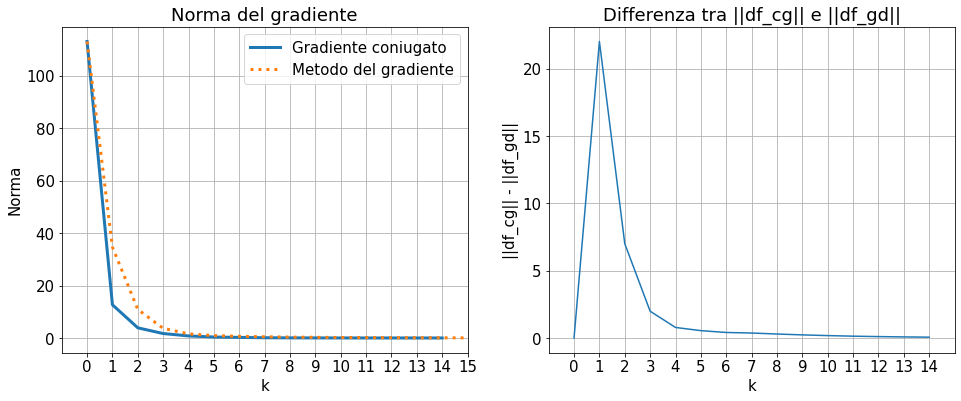

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].grid()
ax[0].set_title("Norma del gradiente")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Norma")
ax[0].plot(range(0, len(df_k_cg)), df_k_cg, label="Gradiente coniugato", linewidth=3)
ax[0].plot(range(0, len(df_k_gd)), df_k_gd, label="Metodo del gradiente", linestyle=":", linewidth=3)
ax[0].legend()
ax[0].set_xticks(range(0, len(df_k_gd)))
ax[0].set_xlim([-1, 15])

ax[1].grid()
ax[1].set_title("Differenza tra ||df_cg|| e ||df_gd||")
ax[1].set_xlabel("k")
ax[1].set_ylabel("||df_cg|| - ||df_gd||")
ax[1].plot(range(0, len(diff_df)), diff_df)
ax[1].set_xticks(range(0, len(diff_df)))
ax[1].set_xlim([-1, 15])

plt.show()


# Semi-convergenza

## Tikhonov

In [123]:
xk_cg = [np.zeros(curr_image.size)]
xk_gd = [np.zeros(curr_image.size)]

out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, callback=lambda xk: append_to(xk, xk_cg))
out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, callback=lambda xk: append_to(xk, xk_gd))

In [124]:
images_cg = [xk.reshape(curr_image.shape) for xk in xk_cg]
images_gd = [xk.reshape(curr_image.shape) for xk in xk_gd]

psnr_k_cg = [f_PSNR(curr_real, image) for image in images_cg]
psnr_k_gd = [f_PSNR(curr_real, image) for image in images_gd]

# mse_k_cg = [f_MSE(curr_real, image) for image in images_cg]
# mse_k_gd = [f_MSE(curr_real, image) for image in images_gd]
# norm_k_cg = [np.linalg.norm(curr_real-image) for image in images_cg]
# norm_k_gd = [np.linalg.norm(curr_real-image) for image in images_gd]

i_best_cg = psnr_k_cg.index(max(psnr_k_cg))
i_best_gd = psnr_k_gd.index(max(psnr_k_gd))


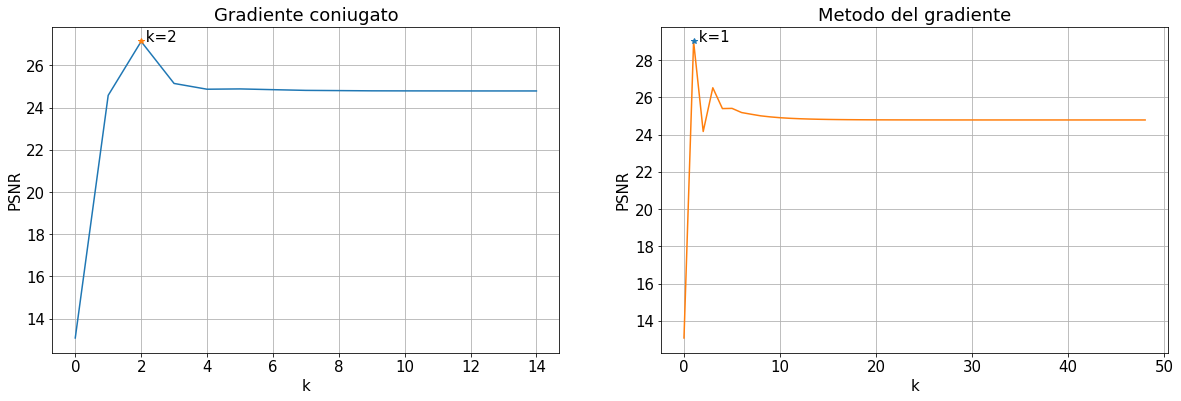

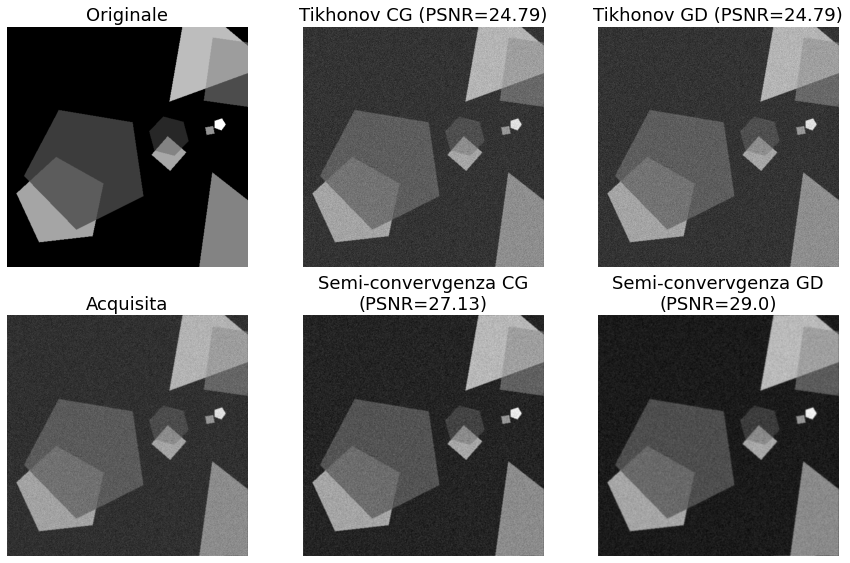

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].grid()
ax[0].set_title("Gradiente coniugato")
ax[0].set_xlabel("k")
ax[0].set_ylabel("PSNR")
ax[0].plot(range(0, len(psnr_k_cg)), psnr_k_cg, label="Gradiente coniugato")
ax[0].plot(i_best_cg, psnr_k_cg[i_best_cg], "*")
ax[0].annotate(f" k={i_best_cg}", (i_best_cg, psnr_k_cg[i_best_cg]))

ax[1].grid()
ax[1].set_title("Metodo del gradiente")
ax[1].set_xlabel("k")
ax[1].set_ylabel("PSNR")
ax[1].plot(range(0, len(psnr_k_gd)), psnr_k_gd, label="Metodo del gradiente", color="tab:orange")
ax[1].plot(i_best_gd, psnr_k_gd[i_best_gd], "*", color="tab:blue")
ax[1].annotate(f" k={i_best_gd}", (i_best_gd, psnr_k_gd[i_best_gd]))

plt.show()


fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0, 0].imshow(curr_real, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")
ax[1, 0].imshow(curr_image, cmap="gray")
ax[1, 0].set_title("Acquisita")
ax[1, 0].axis("off")
ax[0, 1].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[0, 1].set_title(f"Tikhonov CG (PSNR={round(f_PSNR(curr_real, out_tikhonov_cg['image']), 2)})")
ax[0, 1].axis("off")
ax[0, 2].imshow(out_tikhonov_gd["image"], cmap="gray")
ax[0, 2].set_title(f"Tikhonov GD (PSNR={round(f_PSNR(curr_real, out_tikhonov_gd['image']), 2)})")
ax[0, 2].axis("off")

ax[1, 1].imshow(images_cg[i_best_cg], cmap="gray")
ax[1, 1].set_title(f"Semi-convervgenza CG\n(PSNR={round(psnr_k_cg[i_best_cg], 2)})")
ax[1, 1].axis("off")

ax[1, 2].imshow(images_gd[i_best_gd], cmap="gray")
ax[1, 2].set_title(f"Semi-convervgenza GD\n(PSNR={round(psnr_k_gd[i_best_gd], 2)})")
ax[1, 2].axis("off")

plt.show()


## Naive

In [126]:
xk_naive = [np.zeros(curr_image.size)]

out_naive_semi = deblur_naive(curr_image, curr_blur, callback=lambda xk: append_to(xk, xk_naive), max_iter=200)

In [127]:
images_naive = [xk.reshape(curr_image.shape) for xk in xk_naive]

psnr_k_naive = [f_PSNR(curr_real, image) for image in images_naive]

i_best_naive = psnr_k_naive.index(max(psnr_k_naive))

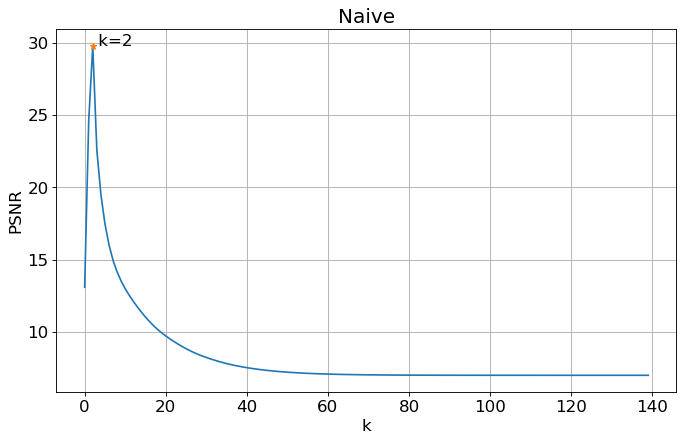

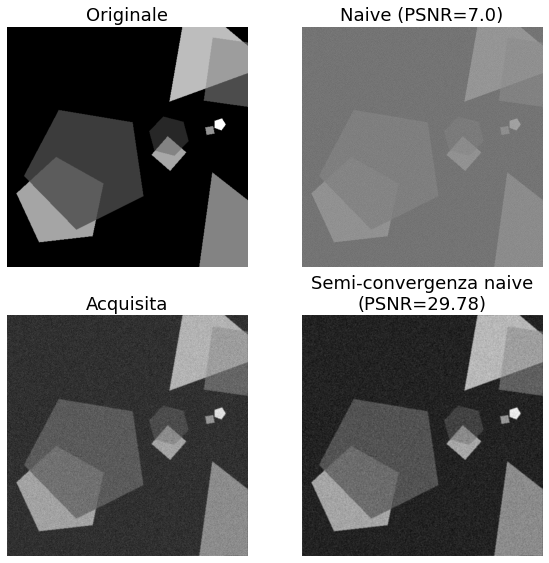

In [128]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("Naive")
plt.xlabel("k")
plt.ylabel("PSNR")
plt.plot(range(0, len(psnr_k_naive)), psnr_k_naive, label="Naive")
plt.plot(i_best_naive, psnr_k_naive[i_best_naive], "*")
plt.annotate(f" k={i_best_naive}", (i_best_naive, psnr_k_naive[i_best_naive]))

plt.show()


fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01, right=0.5, left=0)

ax[0, 0].imshow(curr_real, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")
ax[1, 0].imshow(curr_image, cmap="gray")
ax[1, 0].set_title("Acquisita")
ax[1, 0].axis("off")
ax[0, 1].imshow(out_naive["image"], cmap="gray")
ax[0, 1].set_title(f"Naive (PSNR={round(f_PSNR(curr_real, out_naive['image']), 2)})")
ax[0, 1].axis("off")

ax[1, 1].imshow(images_naive[i_best_naive], cmap="gray")
ax[1, 1].set_title(f"Semi-convergenza naive\n(PSNR={round(f_PSNR(curr_real, images_naive[i_best_naive]), 2)})")
ax[1, 1].axis("off")

plt.show()


## Variazione totale

In [129]:
xk_tv = [np.zeros(curr_image.size)]

out_tv_semi = deblur_tv(curr_image, curr_blur, lambda_tv, callback=lambda xk: append_to(xk, xk_tv))

In [130]:
images_tv = [xk.reshape(curr_image.shape) for xk in xk_tv]

psnr_k_tv = [f_PSNR(curr_real, image) for image in images_tv]

i_best_tv = psnr_k_tv.index(max(psnr_k_tv))

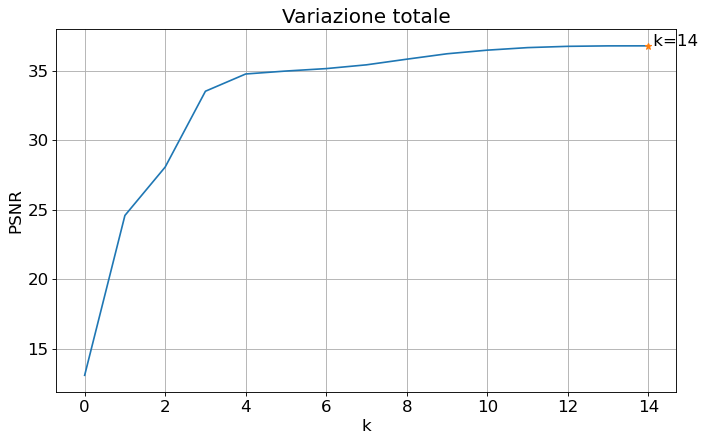

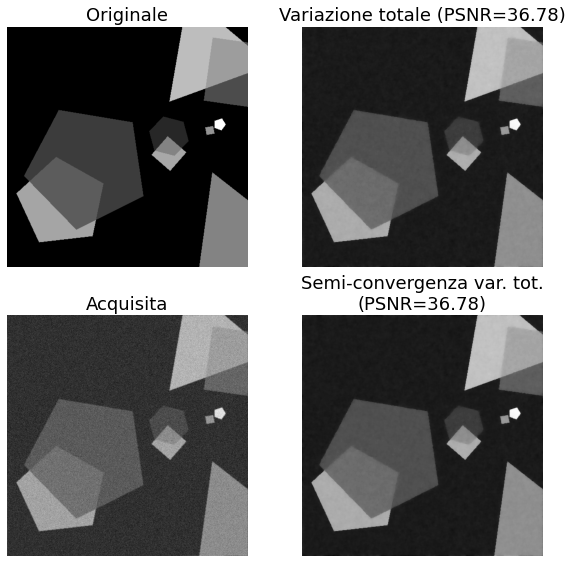

In [131]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("Variazione totale")
plt.xlabel("k")
plt.ylabel("PSNR")
plt.plot(range(0, len(psnr_k_tv)), psnr_k_tv, label="tv")
plt.plot(i_best_tv, psnr_k_tv[i_best_tv], "*")
plt.annotate(f" k={i_best_tv}", (i_best_tv, psnr_k_tv[i_best_tv]))

plt.show()


fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01, right=0.5, left=0)

ax[0, 0].imshow(curr_real, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")
ax[1, 0].imshow(curr_image, cmap="gray")
ax[1, 0].set_title("Acquisita")
ax[1, 0].axis("off")
ax[0, 1].imshow(out_tv["image"], cmap="gray")
ax[0, 1].set_title(f"Variazione totale (PSNR={round(f_PSNR(curr_real, out_tv['image']), 2)})")
ax[0, 1].axis("off")

ax[1, 1].imshow(images_tv[i_best_tv], cmap="gray")
ax[1, 1].set_title(f"Semi-convergenza var. tot.\n(PSNR={round(f_PSNR(curr_real, images_tv[i_best_tv]), 2)})")
ax[1, 1].axis("off")

plt.show()


# Esecuzioni multiple

In [19]:
from PIL import Image
from PIL import ImageDraw
import random
import math

def polygon(sides, radius=1, rotation=0, start_coord=(0, 0)):
    """
        Restituisce la lista dei vertici di un poligono fissate alcune caratteristiche
        Fonte: https://stackoverflow.com/questions/23411688/drawing-polygon-with-n-number-of-sides-in-python-3-2

        PARAMETRI:
            sides        :  Numero di facce
            radius       :  Raggio della circonferenza goniometrica su cui sono calcolati i punti
            rotation     :  Rotazione del poligono
            start_coord  :  Coordinata in cui posizionare il poligono (non fa necessariamente riferimento al vertice in alto a sinistra)
        RETURN: 
            Lista di coordinate
    """
    one_segment = math.pi * 2 / sides
    points = [(math.sin(one_segment * i + rotation) * radius, math.cos(one_segment * i + rotation) * radius) for i in range(sides)]
    points = [(point[0] + start_coord[0], point[1] + start_coord[1]) for point in points]
    return points

def generate_image(width, height, min_poygons=3, max_polygons=6, max_polygon_sides=10):
    """
        Restituisce un'immagine contenente poligoni in scala di grigi normalizzata in [0, 1]

        PARAMETRI:
            width, height      :  Dimensione dell'immagine
            min_poygons        :  Numero minimo di poligoni generati
            max_polygons       :  Numero massimo di poligoni generati
            max_polygon_sides  :  Numero massimo di facce dei poligoni (Minimo 3)

        RETURN: 
            Immagine come matrice Numpy
    """

    out_image = Image.new("RGBA", (width, height))
    num_polygons = random.randrange(min_poygons, max_polygons)

    for i in range(num_polygons):
        # Immagine che conterrà il nuovo poligono
        image = Image.new("RGBA", (width, height))
        draw = ImageDraw.Draw(image)

        # Generazione punti
        points = polygon(
            sides=random.randrange(3, max_polygon_sides),
            radius=random.randrange(int(width / 60), int(width / 3)),
            rotation=random.randrange(0, 359),
            start_coord=(random.randrange(0, width), random.randrange(0, height))
        )

        # Selezione colore
        color = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255), 150)
        draw.polygon((points), fill=color)

        # Sovrapposizione delle immagini
        out_image = Image.alpha_composite(out_image, image)

    return np.array(out_image.convert("L")) / 255  # Immagine in scala di grigi normalizzata in [0, 1]


In [18]:
psnr_naive = []
psnr_tikhonov = []
psnr_tv = []

iter_naive = []
iter_tikhonov = []
iter_tv = []

image_naive = []
image_tikhonov = []
image_tv = []

lambda_tikhonov = 0.1
lambda_tv = 0.05

In [20]:
for i in range(1):
    print(i, end=" ")

    # Creazione immagine
    real_image = generate_image(512, 512)
    blur = gaussian_blur(real_image.shape, 9, 1.3)
    noise = np.random.normal(size=real_image.shape) * 0.05
    image = A(real_image, blur) + noise

    # Esecuzione 
    out_naive = deblur_naive(image, blur, max_iter=100)
    out_tikhonov = deblur_tikhonov_cg(image, blur, lambda_tikhonov)
    out_tv = deblur_tv(image, blur, lambda_tv)

    # PSNR
    psnr_naive.append(f_PSNR(real_image, out_naive["image"]))
    psnr_tikhonov.append(f_PSNR(real_image, out_tikhonov["image"]))
    psnr_tv.append(f_PSNR(real_image, out_tv["image"]))

    # Numero iterazioni
    iter_naive.append(out_naive["n_it"])
    iter_tikhonov.append(out_tikhonov["n_it"])
    iter_tv.append(out_tv["n_it"])

    # Immagine finale
    image_naive.append(out_naive["image"])
    image_tikhonov.append(out_tikhonov["image"])
    image_tv.append(out_tv["image"])


0 

In [21]:
psnr_data1 = [psnr_naive, psnr_tikhonov, psnr_tv]
psnr_data2 = [psnr_tikhonov, psnr_tv]

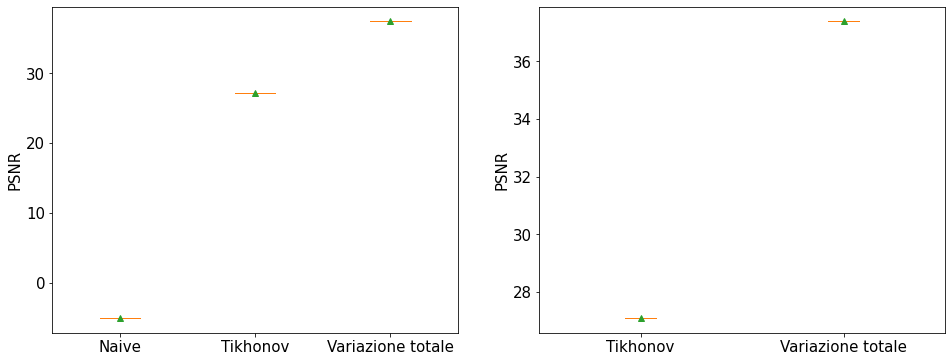

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].boxplot(psnr_data1, labels=["Naive", "Tikhonov", "Variazione totale"], showmeans=True)
ax[0].set_ylabel("PSNR")

boxplot_psnr = ax[1].boxplot(psnr_data2, labels=["Tikhonov", "Variazione totale"], showmeans=True)
ax[1].set_ylabel("PSNR")

plt.show()


In [27]:
print("Tikhonov")
print("Whiskers1", boxplot_psnr["whiskers"][0].get_data())
print("Whiskers2", boxplot_psnr["whiskers"][1].get_data())
print("Mean", boxplot_psnr["means"][0].get_data())
print("Median", boxplot_psnr["medians"][0].get_data())
print("SD", np.std(psnr_tikhonov))
print()
print("TV")
print("Whiskers1", boxplot_psnr["whiskers"][2].get_data())
print("Whiskers2", boxplot_psnr["whiskers"][3].get_data())
print("Mean", boxplot_psnr["means"][1].get_data())
print("Median", boxplot_psnr["medians"][1].get_data())
print("SD", np.std(psnr_tv))


Tikhonov
Whiskers1 (array([1., 1.]), array([27.09651159, 27.09651159]))
Whiskers2 (array([1., 1.]), array([27.09651159, 27.09651159]))
Mean (array([1]), array([27.09651159]))
Median (array([0.925, 1.075]), array([27.09651159, 27.09651159]))
SD 0.0

TV
Whiskers1 (array([2., 2.]), array([37.37600298, 37.37600298]))
Whiskers2 (array([2., 2.]), array([37.37600298, 37.37600298]))
Mean (array([2]), array([37.37600298]))
Median (array([1.925, 2.075]), array([37.37600298, 37.37600298]))
SD 0.0


In [29]:
iter_data1 = [iter_naive, iter_tikhonov, iter_tv]
iter_data2 = [iter_tikhonov, iter_tv]

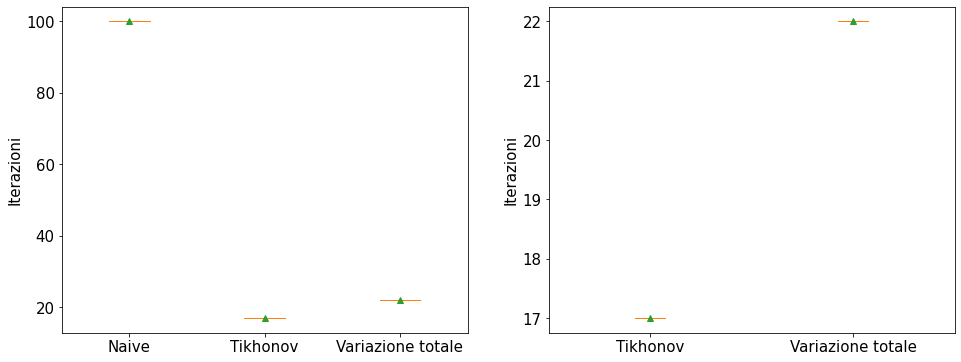

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].boxplot(iter_data1, labels=["Naive", "Tikhonov", "Variazione totale"], showmeans=True, showfliers=True)
ax[0].set_ylabel("Iterazioni")

boxplot_iter = ax[1].boxplot(iter_data2, labels=["Tikhonov", "Variazione totale"], showmeans=True, showfliers=True)
ax[1].set_ylabel("Iterazioni")

plt.show()


In [31]:
print("Tikhonov")
print("whiskers1", boxplot_iter["whiskers"][0].get_data())
print("whiskers2", boxplot_iter["whiskers"][1].get_data())
print("mean", boxplot_iter["means"][0].get_data())
print("median", boxplot_iter["medians"][0].get_data())
print("SD", np.std(iter_tikhonov))
print()
print("TV")
print("whiskers1", boxplot_iter["whiskers"][2].get_data())
print("whiskers2", boxplot_iter["whiskers"][3].get_data())
print("mean", boxplot_iter["means"][1].get_data())
print("median", boxplot_iter["medians"][1].get_data())
print("SD", np.std(iter_tv))


Tikhonov
whiskers1 (array([1., 1.]), array([17., 17.]))
whiskers2 (array([1., 1.]), array([17., 17.]))
mean (array([1]), array([17.]))
median (array([0.925, 1.075]), array([17., 17.]))
SD 0.0

TV
whiskers1 (array([2., 2.]), array([22., 22.]))
whiskers2 (array([2., 2.]), array([22., 22.]))
mean (array([2]), array([22.]))
median (array([1.925, 2.075]), array([22., 22.]))
SD 0.0


# Esecuzioni su dataset

In [ ]:
real_images = []
images = []
blurs = []

kernel_len = 9
kernel_sigma = 0.5

noise_dev = 0.05

# Lettura dataset
for i in range(1, 9):
    real_images = real_images + [plt.imread(f"./dataset/image{i}.png").astype(np.float64)]

# Applicazione blur e noise
for i in range(len(real_images)):
    blurs = blurs + [gaussian_blur(real_images[i].shape, kernel_len, kernel_sigma)]
    noise = np.random.normal(size=real_images[i].shape) * noise_dev
    images = images + [A(real_images[i], blurs[i]) + noise]


In [ ]:
outs_naive = []
outs_tikhonov = []
outs_tv = []
lambda_tikhonov = search_best_lambda(deblur_tikhonov_cg, real_images[0], images[0], blurs[0])
lambda_tv = search_best_lambda(deblur_tv, real_images[0], images[0], blurs[0])

for i in range(len(images)):
    print(i, end=" ")
    outs_naive.append(deblur_naive(images[i], blurs[i], max_iter=50))
    outs_tikhonov.append(deblur_tikhonov_cg(images[i], blurs[i], lambda_tikhonov))
    outs_tv.append(deblur_tv(images[i], blurs[i], lambda_tv))


0 1 2 3 4 5 6 7 

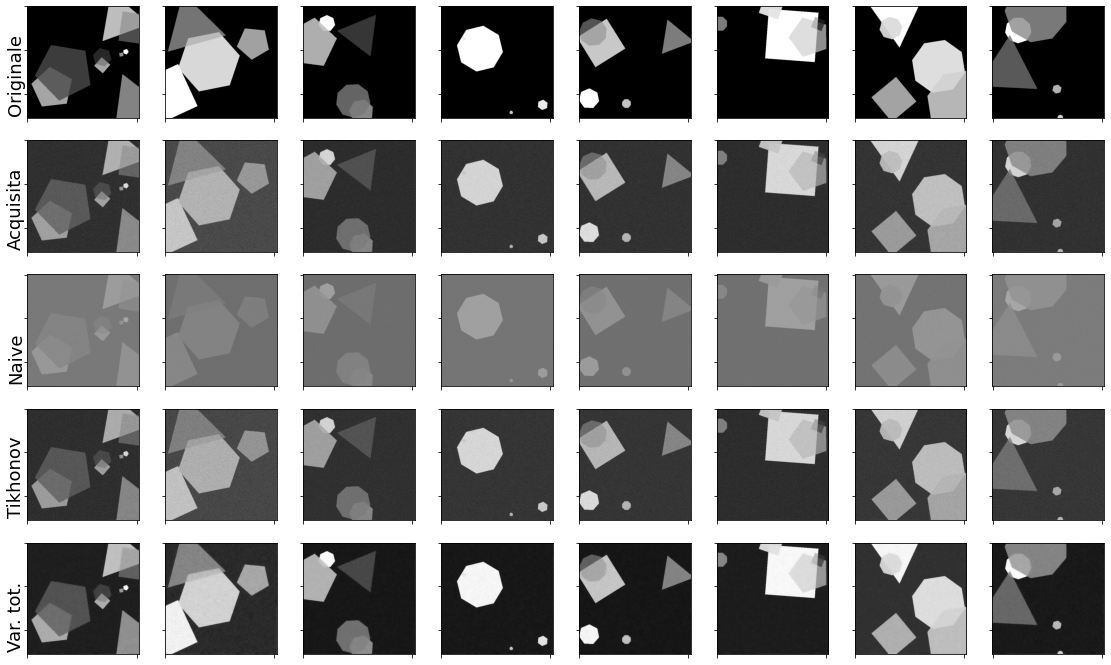

In [ ]:
fig, ax = plt.subplots(5, 8, figsize=(150, 150))
fig.subplots_adjust(top=0.06, bottom=0, right=0.1, left=0)

for i in range(8):
    ax[0, i].imshow(real_images[i], cmap="gray")
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])

    ax[1, i].imshow(images[i], cmap="gray")
    ax[1, i].set_xticklabels([])
    ax[1, i].set_yticklabels([])

    ax[2, i].imshow(outs_naive[i]["image"], cmap="gray")
    ax[2, i].set_xticklabels([])
    ax[2, i].set_yticklabels([])

    ax[3, i].imshow(outs_tikhonov[i]["image"], cmap="gray")
    ax[3, i].set_xticklabels([])
    ax[3, i].set_yticklabels([])

    ax[4, i].imshow(outs_tv[i]["image"], cmap="gray")
    ax[4, i].set_xticklabels([])
    ax[4, i].set_yticklabels([])

ax[0, 0].set_title("Originale", rotation='vertical', x=-0.1, y=0.01)
ax[1, 0].set_title("Acquisita", rotation='vertical', x=-0.1, y=0.01)
ax[2, 0].set_title("Naive", rotation='vertical', x=-0.1, y=0.01)
ax[3, 0].set_title("Tikhonov", rotation='vertical', x=-0.1, y=0.01)
ax[4, 0].set_title("Var. tot.", rotation='vertical', x=-0.1, y=0.01)
plt.show()


In [ ]:
mses_naive_s = [np.format_float_scientific(f_MSE(real_images[i], outs_naive[i]["image"]), 5) for i in range(len(images))]
mses_naive = [f_MSE(real_images[i], outs_naive[i]["image"]) for i in range(len(images))]
psnrs_naive = [round(f_PSNR(real_images[i], outs_naive[i]["image"]), 4) for i in range(len(images))]

mses_tikhonov_s = [np.format_float_scientific(f_MSE(real_images[i], outs_tikhonov[i]["image"]), 5) for i in range(len(images))]
mses_tikhonov = [f_MSE(real_images[i], outs_tikhonov[i]["image"]) for i in range(len(images))]
psnrs_tikhonov = [round(f_PSNR(real_images[i], outs_tikhonov[i]["image"]), 4) for i in range(len(images))]

mses_tv_s = [np.format_float_scientific(f_MSE(real_images[i], outs_tv[i]["image"]), 5) for i in range(len(images))]
mses_tv = [f_MSE(real_images[i], outs_tv[i]["image"]) for i in range(len(images))]
psnrs_tv = [round(f_PSNR(real_images[i], outs_tv[i]["image"]), 4) for i in range(len(images))]


In [ ]:
print(f"Kernel {kernel_len}x{kernel_len} sigma={kernel_sigma} | noise {noise_dev} | lambda {tikhonov_best_lambda} {tv_best_lambda}")
print(f"{'MSE naive':<15} {'MSE Tikhonov':<15} {'MSE TV':<15} {'PSNR naive':<15} {'PSNR Tikhonov':<15} {'PSNR TV':<15} {'Iter. naive':<15} {'Iter Tikhonov':<15} {'Iter tv':<15}")

for i in range(len(images)):
    print(f"{mses_naive_s[i]:<15} {mses_tikhonov_s[i]:<15} {mses_tv_s[i]:<15} {psnrs_naive[i]:<15} {psnrs_tikhonov[i]:<15} {psnrs_tv[i]:<15} {outs_naive[i]['n_it']:<15} {outs_tikhonov[i]['n_it']:<15} {outs_tv[i]['n_it']:<15}")

print()
print(f"{'':<15} {'Naive':<25} {'Tikhonov':<25} {'Variazione totale':<25}")
print(f"{'Media PSNR':<15} {np.mean(psnrs_naive):<25} {np.mean(psnrs_tikhonov):<25} {np.mean(psnrs_tv):<25}")
print(f"{'Dev. std. PSNR':<15} {np.std(psnrs_naive):<25} {np.std(psnrs_tikhonov):<25} {np.std(psnrs_tv):<25}")
print(f"{'Media MSE':<15} {np.mean(mses_naive):<25} {np.mean(mses_tikhonov):<25} {np.mean(mses_tv):<25}")
print(f"{'Dev. std. MSE':<15} {np.std(mses_naive):<25} {np.std(mses_tikhonov):<25} {np.std(mses_tv):<25}")

Kernel 9x9 sigma=0.5 | noise 0.05 | lambda 0.51 0.21000000000000002
MSE naive       MSE Tikhonov    MSE TV          PSNR naive      PSNR Tikhonov   PSNR TV         Iter. naive     Iter Tikhonov   Iter tv        
1.94554e-01     3.31685e-03     2.1252e-04      7.1096          24.7927         36.726          50              14              14             
1.96085e-01     3.14451e-03     1.68147e-04     7.0756          25.0245         37.7431         50              14              16             
1.92650e-01     3.47976e-03     1.9366e-04      7.1523          24.5845         37.1296         50              14              15             
1.92850e-01     3.87514e-03     2.20320e-04     7.1478          24.1171         36.5695         50              15              12             
1.94059e-01     3.53865e-03     2.77707e-04     7.1207          24.5116         35.5641         50              14              10             
1.90852e-01     5.65833e-03     1.86145e-04     7.193           22.4

## Auto

In [ ]:
def fortranFormat(n):
    a = '{:.1E}'.format(float(n))
    e = a.find('E')

    sign = a[e + 1]
    if a[e + 1] == "+" or int(a[e + 1:]) + 1 == 0:
        sign = ""

    return f"0.{a[0]}{a[2:e]} \cdot 10^{{{sign}{abs(int(a[e + 1:]) + 1):d}}}"

('9_12', 10, 60, 0.05)


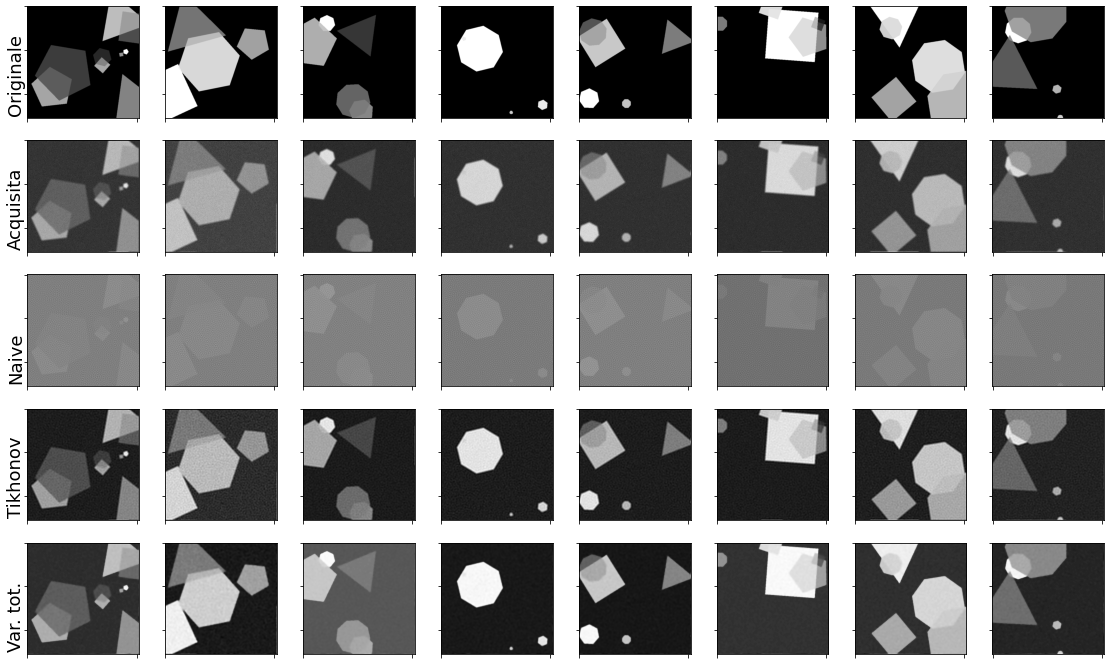

In [ ]:
confs = [
    ("9_12", 10, 60, 0.05),
]

for conf in confs:
    print(conf)
    real_images = []
    images = []
    blurs = []

    folder = conf[0]
    kernel_len = conf[1]
    kernel_sigma = conf[2]
    noise_dev = conf[3]

    # Generazione
    for i in range(1, 9):
        real_images = real_images + [plt.imread(f"./dataset/image{i}.png").astype(np.float64)]

    for i in range(len(real_images)):
        blurs = blurs + [gaussian_blur(real_images[i].shape, kernel_len, kernel_sigma)]
        noise = np.random.normal(size=real_images[i].shape) * noise_dev
        images = images + [A(real_images[i], blurs[i]) + noise]

    # Deblur
    outs_naive = []
    outs_tikhonov = []
    outs_tv = []
    lambda_tikhonov = search_best_lambda(deblur_tikhonov_cg, real_images[0], images[0], blurs[0])
    lambda_tv = search_best_lambda(deblur_tv, real_images[0], images[0], blurs[0])

    for i in range(len(images)):
        outs_naive = outs_naive + [deblur_naive(images[i], blurs[i], max_iter=50)]
        outs_tikhonov = outs_tikhonov + [deblur_tikhonov_cg(images[i], blurs[i], lambda_tikhonov)]
        outs_tv = outs_tv + [deblur_tv(images[i], blurs[i], lambda_tv)]

    # Visualizzazione
    fig, ax = plt.subplots(5, 8, figsize=(150, 150))
    fig.subplots_adjust(top=0.06, bottom=0, right=0.1, left=0)

    for i in range(8):
        ax[0, i].imshow(real_images[i], cmap="gray")
        ax[0, i].set_xticklabels([])
        ax[0, i].set_yticklabels([])

        ax[1, i].imshow(images[i], cmap="gray")
        ax[1, i].set_xticklabels([])
        ax[1, i].set_yticklabels([])

        ax[2, i].imshow(outs_naive[i]["image"], cmap="gray")
        ax[2, i].set_xticklabels([])
        ax[2, i].set_yticklabels([])

        ax[3, i].imshow(outs_tikhonov[i]["image"], cmap="gray")
        ax[3, i].set_xticklabels([])
        ax[3, i].set_yticklabels([])

        ax[4, i].imshow(outs_tv[i]["image"], cmap="gray")
        ax[4, i].set_xticklabels([])
        ax[4, i].set_yticklabels([])

    ax[0, 0].set_title("Originale", rotation='vertical', x=-0.1, y=0.01)
    ax[1, 0].set_title("Acquisita", rotation='vertical', x=-0.1, y=0.01)
    ax[2, 0].set_title("Naive", rotation='vertical', x=-0.1, y=0.01)
    ax[3, 0].set_title("Tikhonov", rotation='vertical', x=-0.1, y=0.01)
    ax[4, 0].set_title("Var. tot.", rotation='vertical', x=-0.1, y=0.01)

    plt.show()

    # Dati
    mses_naive_s = [np.format_float_scientific(f_MSE(real_images[i], outs_naive[i]["image"]), 5) for i in range(len(images))]
    mses_naive = [f_MSE(real_images[i], outs_naive[i]["image"]) for i in range(len(images))]
    psnrs_naive = [round(f_PSNR(real_images[i], outs_naive[i]["image"]), 4) for i in range(len(images))]

    mses_tikhonov_s = [np.format_float_scientific(f_MSE(real_images[i], outs_tikhonov[i]["image"]), 5) for i in range(len(images))]
    mses_tikhonov = [f_MSE(real_images[i], outs_tikhonov[i]["image"]) for i in range(len(images))]
    psnrs_tikhonov = [round(f_PSNR(real_images[i], outs_tikhonov[i]["image"]), 4) for i in range(len(images))]

    mses_tv_s = [np.format_float_scientific(f_MSE(real_images[i], outs_tv[i]["image"]), 5) for i in range(len(images))]
    mses_tv = [f_MSE(real_images[i], outs_tv[i]["image"]) for i in range(len(images))]
    psnrs_tv = [round(f_PSNR(real_images[i], outs_tv[i]["image"]), 4) for i in range(len(images))]

    with open(f"E:/Uni/Calcolo numerico/calcolo-imaging/Relazione/img/esecuzioni_multiple/dataset/{folder}/desc.txt", "w") as f:
        f.write(f"Kernel {kernel_len}x{kernel_len} sigma={kernel_sigma} | noise {noise_dev} | lambda {lambda_tikhonov} {lambda_tv}\n")
        f.write(f"{'MSE naive':<15} {'MSE Tikhonov':<15} {'MSE TV':<15} {'PSNR naive':<15} {'PSNR Tikhonov':<15} {'PSNR TV':<15} {'Iter. naive':<15} {'Iter Tikhonov':<15} {'Iter tv':<15}\n")

        for i in range(len(images)):
            f.write(f"{mses_naive_s[i]:<15} {mses_tikhonov_s[i]:<15} {mses_tv_s[i]:<15} {psnrs_naive[i]:<15} {psnrs_tikhonov[i]:<15} {psnrs_tv[i]:<15} {outs_naive[i]['n_it']:<15} {outs_tikhonov[i]['n_it']:<15} {outs_tv[i]['n_it']:<15}\n")

        f.write("\n")
        f.write(f"{'Media PSNR Naive':<25} {np.mean(psnrs_naive)}\n")
        f.write(f"{'Media PSNR Tikhonov':<25} {np.mean(psnrs_tikhonov)}\n")
        f.write(f"{'Media PSNR TV':<25} {np.mean(psnrs_tv)}\n")
        f.write("\n")
        f.write(f"{'SD PSNR Naive':<25} {np.std(psnrs_naive)}\n")
        f.write(f"{'SD PSNR Tikhonov':<25} {np.std(psnrs_tikhonov)}\n")
        f.write(f"{'SD PSNR TV':<25} {np.std(psnrs_tv)}\n")
        f.write("\n")
        f.write(f"{'Media MSE Naive':<25} {np.mean(mses_naive)}\n")
        f.write(f"{'Media MSE Tikhonov':<25} {np.mean(mses_tikhonov)}\n")
        f.write(f"{'Media MSE TV':<25} {np.mean(mses_tv)}\n")
        f.write("\n")
        f.write(f"{'SD MSE Naive':<25} {np.std(mses_naive)}\n")
        f.write(f"{'SD MSE Tikhonov':<25} {np.std(mses_tikhonov)}\n")
        f.write(f"{'SD MSE TV':<25} {np.std(mses_tv)}\n")

        mse1 = fortranFormat(np.mean(mses_naive))
        mse2 = fortranFormat(np.mean(mses_tikhonov))
        mse3 = fortranFormat(np.mean(mses_tv))
        psnr1 = round(np.mean(psnrs_naive), 2)
        psnr2 = round(np.mean(psnrs_tikhonov), 2)
        psnr3 = round(np.mean(psnrs_tv), 2)

        f.write("\n\n\n")
        f.write(f"${kernel_len} \\times {kernel_len}$ & $\\sigma={kernel_sigma}$ & $\\sigma={noise_dev}$ & ${mse1}$ & ${mse2}$ & ${mse3}$ & {psnr1} & {psnr2} & {psnr3} \\\\")


# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

